In [1]:
import rasterio
import os
from datetime import datetime
import numpy as np

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')

In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

In [5]:
PCR_configfile = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')

PCR_bmi = PCR_model(PCR_configfile, PCR_in_dir, PCR_out_dir,
                            start_date, end_date, dt=1)


## create CMF model BMi object

In [6]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date, dt=86400)




## initialize upstream hydrological model to expose LDD via BMI

In [7]:
# initialize model at PCR_out_dir
PCR_bmi.initialize()
# get model grid defition and index
PCR_bmi.get_model_grid()

2018-02-12 11:17:24,783 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-02-12 11:17:24.777148
2018-02-12 11:17:24,783 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR/PCR/log/setup_PCR_30min_Elbe.ini_2018-02-12T11:17:24.777148.log
2018-02-12 11:17:24,784 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-02-12 11:17:24,785 pcrglobwb_bmi_v203.configuration INFO The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this run. Note that the "subDischargeIni" is only relevant if kinematic wave approaches are used.
2018-02-12 11:17:24,785 pcrglobwb_bmi_v203.currTimeStep INFO number of time steps :10
2018-02-12 11:17:25,037 pcrglobwb_bmi_v203.meteo INFO No forcing downscaling is implemented.
2018-02-12 11:17:31,809 pcrglobwb_bmi_v203.deterministic_runner INFO Adjusting some model parameters ba

## set coupling

In [8]:
# set inpmat based on upstream hydrological model
bounds, res = PCR_bmi.model_grid_bounds, PCR_bmi.model_grid_res
CMF_bmi.set_inpmat_file(bounds, res)

# reset PCR ldd -> no routing
PCR_bmi.deactivate_LDD('all')

# set update states function
def PCR2CMF_runoff(PCR_bmi, CMF_bmi):
    "creates a 'get_runoff' function to get runoff from PCR model fit for CMF model"
    def update_states():
        "coupling runoff between CMFan PCR model"
        runoff = PCR_bmi.get_var('landSurfaceRunoff')
        runoff = np.where(np.isnan(runoff), 0, runoff)
        CMF_bmi.set_var("runoff", runoff)
    return update_states

update_states = PCR2CMF_runoff(PCR_bmi, CMF_bmi)

2018-02-12 11:17:49,983 coupling_PCR_FM.model_functions_v2 INFO ./generate_inpmat 0.5 7.0 17.0 55.0 48.0 NtoS


## initialize downstream routing model

In [9]:
# initialize model at CMF_out_dir
CMF_bmi.initialize()

2018-02-12 11:17:55,629 coupling_PCR_FM.model_functions_v2 INFO Ini file for CaMa-Flood written to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR/CMF/input_flood.nam
2018-02-12 11:17:55,631 bmi.wrapper INFO Loading model /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR/CMF/input_flood.nam in directory /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR/CMF
2018-02-12 11:17:55,639 coupling_PCR_FM.model_functions_v2 INFO CaMa-Flood initialized


## run coupled PCR - CMF model

In [10]:
# run coupled model for 20 timesteps
for i in range(20):
    PCR_bmi.update()
    update_states()
    CMF_bmi.update()   

2018-02-12 11:17:59,875 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
2018-02-12 11:18:00,009 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
2018-02-12 11:18:01,159 coupling_PCR_FM.model_functions_v2 INFO PCRGLOB-WB -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-02-12 11:18:01,208 coupling_PCR_FM.model_functions_v2 INFO CaMa-Flood -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-02-12 11:18:01,209 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
2018-02-12 11:18:01,389 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-02
2018-02-12 11:18:02,053 coupling_PCR_FM.model_functions_v2 INFO PCRGLOB-WB -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2
2018-02-12 11:18:02,069 coupling_PCR_FM.model_functions_v2 INFO CaMa-Flood -> start_time: 2000-01-01 00:00:00, current_time 2000-01-03 00:00:00, timestep 86400.0
2018-02-12 11:18:02,070 pc

2018-02-12 11:18:14,665 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-18
2018-02-12 11:18:14,850 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-18
2018-02-12 11:18:15,501 coupling_PCR_FM.model_functions_v2 INFO PCRGLOB-WB -> start_time: 2000-01-01, current_time 2000-01-18, timestep 18
2018-02-12 11:18:15,526 coupling_PCR_FM.model_functions_v2 INFO CaMa-Flood -> start_time: 2000-01-01 00:00:00, current_time 2000-01-19 00:00:00, timestep 86400.0
2018-02-12 11:18:15,527 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-19
2018-02-12 11:18:15,688 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-19
2018-02-12 11:18:16,321 coupling_PCR_FM.model_functions_v2 INFO PCRGLOB-WB -> start_time: 2000-01-01, current_time 2000-01-19, timestep 19
2018-02-12 11:18:16,356 coupling_PCR_FM.model_functions_v2 INFO CaMa-Flood -> start_time: 2000-01-01 00:00:00, current_time 2000-01-20 00:00:00, timestep 86400.0
2018-02-12 11:18:16,356 

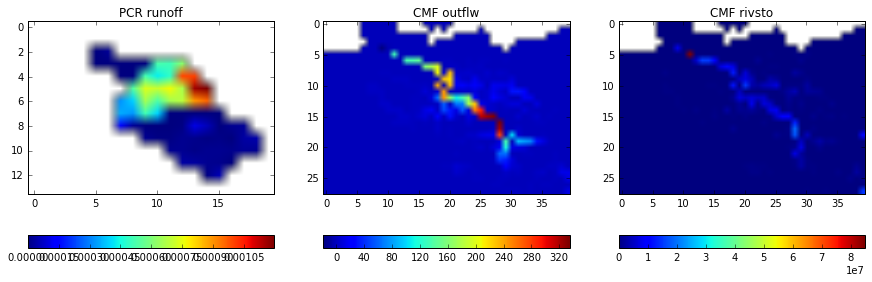

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# PCR_bmi.update()
# routingModel.update_states()
# routingModel.update() 

runoff = PCR_bmi.get_var('landSurfaceRunoff')
outflw = CMF_bmi.get_var('outflw')
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = CMF_bmi.get_var('rivsto_out')
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [12]:
# finalize model
PCR_bmi.finalize()

# finalize model
CMF_bmi.finalize()

2018-02-12 11:19:18,078 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
